This notebook was adapted from the demo for UrbanAccess provided by UrbanSim: https://github.com/UDST/urbanaccess

In [1]:
import matplotlib
matplotlib.use('agg')  # allows notebook to be tested in Travis

import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import pandana as pdna
import time

import urbanaccess as ua
from urbanaccess.config import settings
from urbanaccess.gtfsfeeds import feeds
from urbanaccess import gtfsfeeds
from urbanaccess.gtfs.gtfsfeeds_dataframe import gtfsfeeds_dfs
from urbanaccess.network import ua_network, load_network

%matplotlib inline

In [2]:
# Set default options in UrbanAccess

settings.to_dict()

{'data_folder': 'data',
 'logs_folder': 'logs',
 'log_file': True,
 'log_console': False,
 'log_name': 'urbanaccess',
 'log_filename': 'urbanaccess',
 'txt_encoding': 'utf-8',
 'gtfs_api': {'gtfsdataexch': 'http://www.gtfs-data-exchange.com/api/agencies?format=csv'}}

## Build Transit Network

In [3]:
# Create a feeds object for storing GTFS feeds

feeds.to_dict()

{'gtfs_feeds': {}}

In [4]:
# Add the BART GTFS feed
# Information at https://www.bart.gov/schedules/developers/gtfs

feeds.add_feed(add_dict={'Bay Area Rapid Transit': 'http://www.bart.gov/dev/schedules/google_transit.zip'})

Added 1 feeds to gtfs_feeds: {'Bay Area Rapid Transit': 'http://www.bart.gov/dev/schedules/google_transit.zip'}


In [5]:
# # Search for and add the BART GTFS feed.

# gtfsfeeds.search(search_text='Bay Area Rapid Transit',
#                  search_field=None,
#                  match='contains',
#                  add_feed=True)

In [6]:
# Add the AC Transit GTFS feed
# Information at https://www.actransit.org/data-api-resource-center

feeds.add_feed(add_dict={'ac transit': 'https://api.actransit.org/transit/gtfs/download?token=2512B81107A09D2DC44895CDDC650D47'})

Added 1 feeds to gtfs_feeds: {'ac transit': 'https://api.actransit.org/transit/gtfs/download?token=2512B81107A09D2DC44895CDDC650D47'}


In [7]:
# Check to make sure the feeds have been added properly

feeds.to_dict()

{'gtfs_feeds': {'Bay Area Rapid Transit': 'http://www.bart.gov/dev/schedules/google_transit.zip',
  'ac transit': 'https://api.actransit.org/transit/gtfs/download?token=2512B81107A09D2DC44895CDDC650D47'}}

In [8]:
# Download the feeds into the data folder

gtfsfeeds.download()

2 GTFS feed(s) will be downloaded here: data/gtfsfeed_zips
Bay Area Rapid Transit GTFS feed downloaded successfully. Took 0.73 seconds for 6,134,060.0KB
ac transit GTFS feed downloaded successfully. Took 1.71 seconds for 11,309,395.0KB
GTFS feed download completed. Took 2.44 seconds
ac transit.zip successfully extracted to: data/gtfsfeed_text/ac transit
Bay Area Rapid Transit.zip successfully extracted to: data/gtfsfeed_text/Bay Area Rapid Transit
GTFS feed zipfile extraction completed. Took 0.42 seconds for 2 files


In [9]:
# Set the bounding box for the area of study (City of Oakland)

# oak_bbox = (-122.355881,37.632226,-122.114775,37.884725)
region_bbox = (-122.4325,37.4218,-121.5406,38.0623)

In [10]:
# Load the transit data into a collection of DataFrames

loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path= None,
                                           validation= True,
                                           verbose= True,
                                           bbox= region_bbox,
                                           remove_stops_outsidebbox = True,
                                           append_definitions= True)

Checking GTFS text file header whitespace... Reading files using encoding: utf-8 set in configuration.
GTFS text file header whitespace check completed. Took 0.20 seconds
--------------------------------
Processing GTFS feed: ac transit
The unique agency id: ac_transit was generated using the name of the agency in the agency.txt file.
Unique agency id operation complete. Took 0.03 seconds
Unique GTFS feed id operation complete. Took 0.00 seconds
Records:
     stop_id  stop_code                              stop_name  stop_desc  \
635     6051      52686            S Milpitas Blvd & Garden St        NaN   
3656    6052      52687              S Milpitas Blvd & Ames Av        NaN   
4144    6047      52671                Milpitas BART VTA Bay 9        NaN   
4311    6050      52685  S Milpitas Blvd & Montague Expressway        NaN   
4562    6053      52689              S Milpitas Blvd & Ames Av        NaN   

       stop_lat    stop_lon zone_id  stop_url  location_type  parent_station  

In [11]:
# Create a travel-time-weighted transit network from the GTFS feeds.
# Specify the network for midday on a saturday when people are likely to visit parks.

ua.gtfs.network.create_transit_net(gtfsfeeds_dfs=loaded_feeds,
                                   day='saturday',
                                   timerange=['11:00:00', '14:00:00'],
                                   calendar_dates_lookup=None)

Using calendar to extract service_ids to select trips.
5 service_ids were extracted from calendar
4,645 trip(s) 27.91 percent of 16,643 total trip records were found in calendar for GTFS feed(s): ['ac transit', 'bay area rapid transit']
NOTE: If you expected more trips to have been extracted and your GTFS feed(s) have a calendar_dates file, consider utilizing the calendar_dates_lookup parameter in order to add additional trips based on information inside of calendar_dates. This should only be done if you know the corresponding GTFS feed is using calendar_dates instead of calendar to specify service_ids. When in doubt do not use the calendar_dates_lookup parameter.
4,645 of 16,643 total trips were extracted representing calendar day: saturday. Took 0.03 seconds
There are no departure time records missing from trips following the specified schedule. There are no records to interpolate.
Difference between stop times has been successfully calculated. Took 0.58 seconds
Stop times from 11:00

In [12]:
# Calculate route stop level average headways 
# to approximate passenger wait times at stops and stations.

ua.gtfs.headways.headways(gtfsfeeds_df=loaded_feeds,
                          headway_timerange=['11:00:00','14:00:00'])

Stop times from 11:00:00 to 14:00:00 successfully selected 30,799 records out of 180,449 total records (17.07 percent of total). Took 0.01 seconds
Starting route stop headway calculation for 4,744 route stops...
Route stop headway calculation complete. Took 6.04 seconds
headway calculation complete. Took 6.41 seconds


In [13]:
# Save the transit network to a variable

urbanaccess_net = ua.network.ua_network

<AxesSubplot:xlabel='x', ylabel='y'>

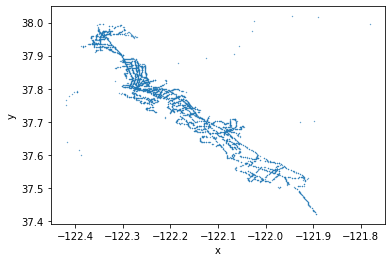

In [14]:
# Visualize the transit network

urbanaccess_net.transit_nodes.plot(kind='scatter', x='x', y='y', s=0.1)

## Build Pedestrian Network

In [15]:
# Download OSM pedestrian street network data

nodes, edges = ua.osm.load.ua_network_from_bbox(bbox= region_bbox,
                                                remove_lcn=True)

Requesting network data within bounding box from Overpass API in 4 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](37.42180000,-122.43250883,37.74590440,-121.98462441);>;);out;'}"
Downloaded 76,530.0KB from www.overpass-api.de in 7.85 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](37.74289691,-122.43250883,38.06314595,-121.98021423);>;);out;'}"
Downloaded 81,400.7KB from www.overpass-api.de in 13.52 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pede

In [16]:
# Create a travel-time-weighted pedestrian network.
# It is automatically added to the same variable as the transit network

ua.osm.network.create_osm_net(osm_edges=edges,
                              osm_nodes=nodes,
                              travel_speed_mph=3)

Created OSM network with travel time impedance using a travel speed of 3 MPH. Took 0.02 seconds


<AxesSubplot:xlabel='x', ylabel='y'>

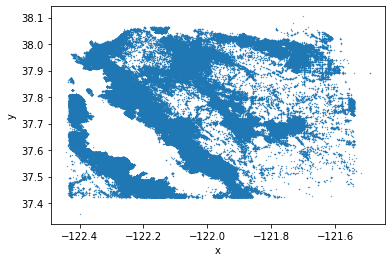

In [17]:
# Visualize the pedestrian network

urbanaccess_net.osm_nodes.plot(kind='scatter', x='x', y='y', s=0.1)

## Integrate Transit + Pedestrian Networks

In [18]:
# Integrate the networks (still in our urbanaccess_net variable)

ua.network.integrate_network(urbanaccess_network=urbanaccess_net,
                             headways=True,
                             urbanaccess_gtfsfeeds_df=loaded_feeds,
                             headway_statistic='mean')

Loaded UrbanAccess network components comprised of:
     Transit: 3,640 nodes and 29,812 edges;
     OSM: 353,139 nodes and 989,554 edges
routes successfully joined to transit nodes. Took 0.04 seconds
Connector edges between the OSM and transit network nodes successfully completed. Took 1.58 seconds
mean route stop headway will be used for pedestrian to transit edge impedance.
Headway impedance calculation completed. Took 0.02 seconds
Edge and node tables formatted for Pandana with integer node ids: id_int, to_int, and from_int. Took 10.01 seconds
Network edge and node network integration completed successfully resulting in a total of 357,883 nodes and 1,054,909 edges:
     Transit: 4,744 nodes 29,812 edges;
     OSM: 353,139 nodes 989,554 edges; and
     OSM/Transit connector: 35,543 edges.


Figure created. Took 63.85 seconds


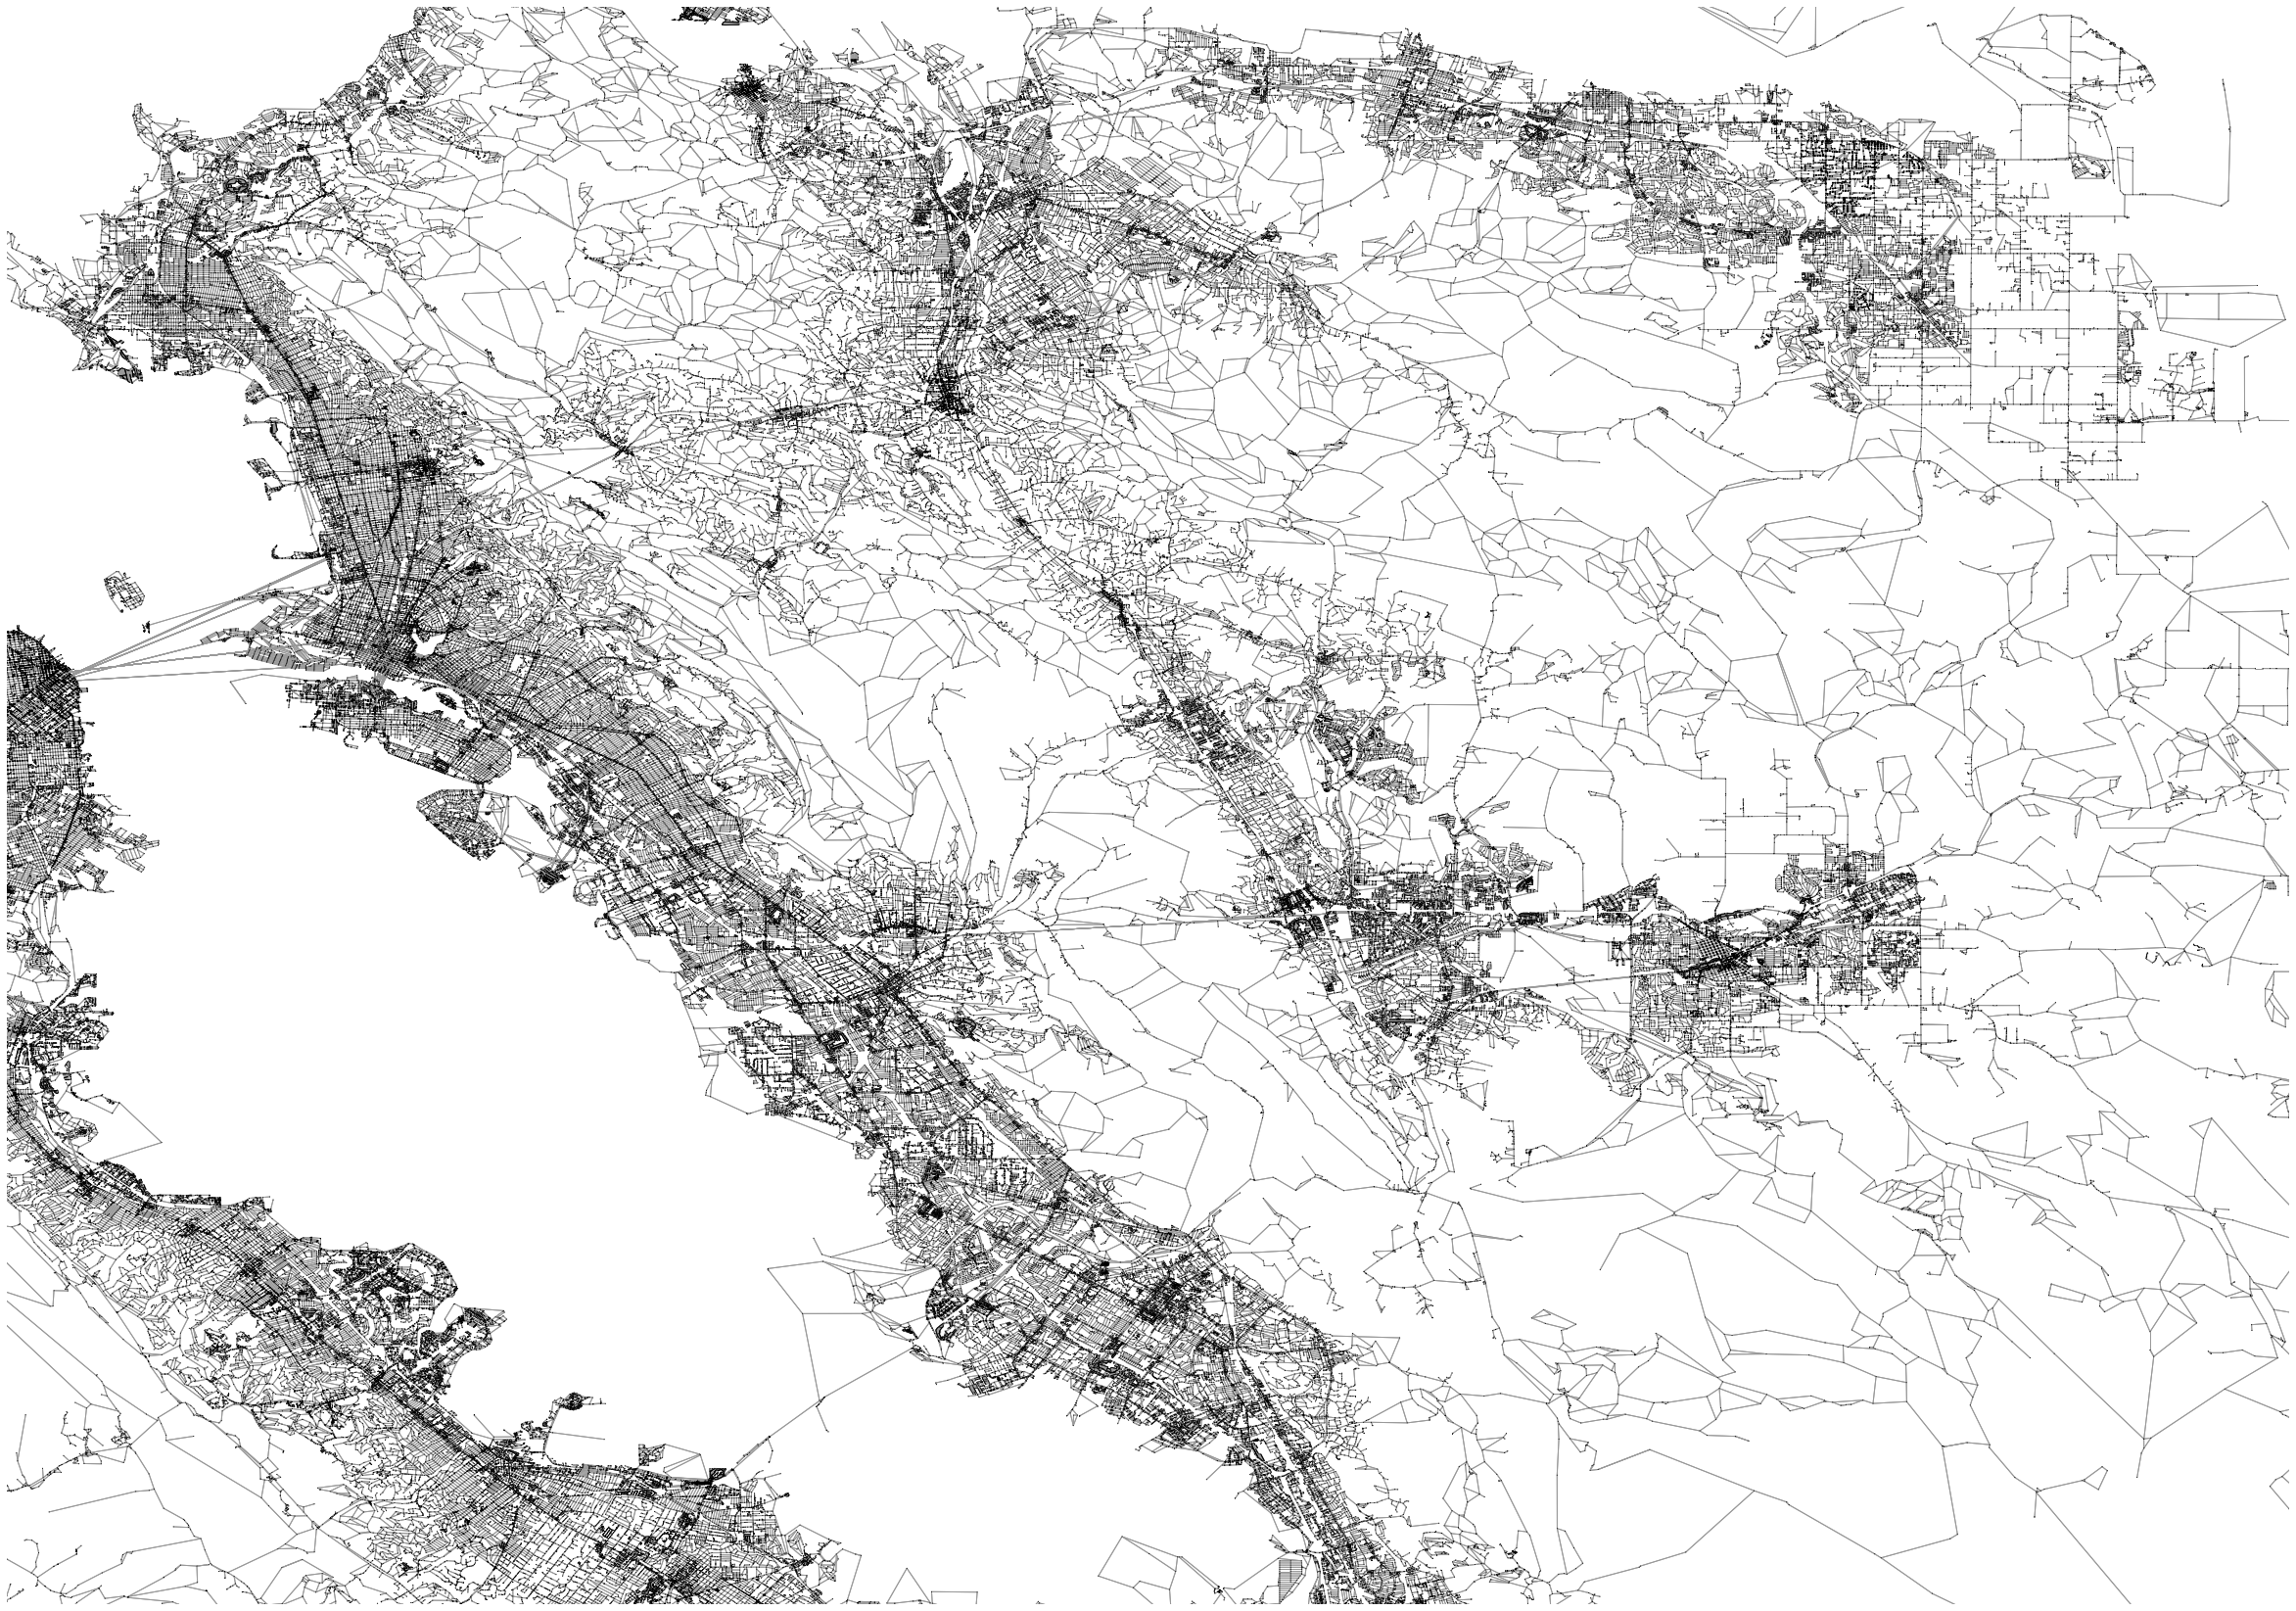

(<Figure size 3007.81x2160 with 1 Axes>, <AxesSubplot:>)

In [19]:
# Visualize the integrated network

ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges,
                 bbox=region_bbox,
                 fig_height=30, margin=0.02,
                 edge_color='#999999', edge_linewidth=1, edge_alpha=1,
                 node_color='black', node_size=1.1, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

In [20]:
# # Save the network as an HDF5 file

# ua.network.save_network(urbanaccess_network=urbanaccess_net,
#                         filename='final_net.h5',
#                         overwrite_key = True)

In [21]:
# # Load the saved network from file

# urbanaccess_net = ua.network.load_network(filename='final_net.h5')

## Calculate Accessibility

In [22]:
# Initialize a pandana network

transit_ped_net = pdna.Network(urbanaccess_net.net_nodes["x"],
                               urbanaccess_net.net_nodes["y"],
                               urbanaccess_net.net_edges["from_int"],
                               urbanaccess_net.net_edges["to_int"],
                               urbanaccess_net.net_edges[["weight"]], 
                               twoway=False)

Generating contraction hierarchies with 12 threads.
Setting CH node vector of size 357883
Setting CH edge vector of size 1054909
Range graph removed 1110128 edges of 2109818
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [73]:
# Read in the park entrance data

parks_df = gpd.read_file("data/Park_Entrances.shp")
print(parks_df.shape)
parks_df.head()

(268, 87)


OBJECTID_1              ENTR_TYPE                        PARK  \
0          14     Trail Staging Area                SF Bay Trail   
1          15           Staging Area  Carquinez Strait Shoreline   
2          32  Walk in Entrance/Gate  Carquinez Strait Shoreline   
3          33  Walk in Entrance/Gate  Carquinez Strait Shoreline   
4          34                Service  Carquinez Strait Shoreline   

                                     NAME  \
0  Pinole Shores Drive Trail Staging Area   
1                    Nejedly Staging Area   
2            Rankin Park Walk-In Entrance   
3          Foster Street Walk-In Entrance   
4           Wallin Drive Walk-In Entrance   

                                            SOURCE WALKING BIKING SWIM_POOL  \
0  Digitized MPeterson 7/08 (from Supvsr comments)       Y      Y         N   
1                          Digitized Khass 11/2006       Y      Y         N   
2                          Digitized Khass 11/2006       Y      Y         N   
3                          Digitized Khass 11/2006       Y      Y         N   
4                          Digitized Khass 11/2006       Y      Y         N   

  SWIM_LAKE DOG_WALK  ...            I_GCAMP            I_BPCAMP  \
0         N        Y  ...  i_no_gcamp_35.gif  i_no_bpcamp_35.gif   
1         N        Y  ...  i_no_gcamp_35.gif  i_no_bpcamp_35.gif   
2         N        Y  ...  i_no_gcamp_35.gif  i_no_bpcamp_35.gif   
3         N        Y  ...  i_no_gcamp_35.gif  i_no_bpcamp_35.gif   
4         N        Y  ...  i_no_gcamp_35.gif  i_no_bpcamp_35.gif   

             I_FCAMP           LEGEND SLOOPHIKE  \
0  i_no_fcamp_35.gif  icon_legend.htm         N   
1  i_no_fcamp_35.gif  icon_legend.htm         N   
2  i_no_fcamp_35.gif  icon_legend.htm         N   
3  i_no_fcamp_35.gif  icon_legend.htm         N   
4  i_no_fcamp_35.gif  icon_legend.htm         N   

                                            PARK_MAP  \
0                                                n/a   
1  http://www.ebparks.org//civicax/filebank/blobd...   
2  http://www.ebparks.org//civicax/filebank/blobd...   
3  http://www.ebparks.org//civicax/filebank/blobd...   
4  http://www.ebparks.org//civicax/filebank/blobd...   

                                          ACTIVITIES      CITY       JPG  \
0                                 Sorry_no_Activ.htm    Pinole  0562.jpg   
1  https://apm.activecommunities.com/ebparks/Acti...  Martinez  0005.jpg   
2  https://apm.activecommunities.com/ebparks/Acti...  Martinez  0413.jpg   
3  https://apm.activecommunities.com/ebparks/Acti...  Martinez  0415.jpg   
4                                 Sorry_no_Activ.htm  Martinez  0416.jpg   

                          geometry  
0  POINT (6039604.108 2195239.535)  
1  POINT (6087181.415 2197336.681)  
2  POINT (6087876.842 2196385.476)  
3  POINT (6088184.765 2196781.161)  
4  POINT (6090108.974 2189505.416)  

[5 rows x 87 columns]

In [74]:
parks_df.crs

<Projected CRS: EPSG:2227>
Name: NAD83 / California zone 3 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Alameda; Calaveras; Contra Costa; Madera; Marin; Mariposa; Merced; Mono; San Francisco; San Joaquin; San Mateo; Santa Clara; Santa Cruz; Stanislaus; Tuolumne.
- bounds: (-123.02, 36.73, -117.83, 38.71)
Coordinate Operation:
- name: SPCS83 California zone 3 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [75]:
# Reproject the park entrance data

parks_df = parks_df.to_crs("EPSG:4326")
parks_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [86]:
parks_df.head()

OBJECTID_1              ENTR_TYPE                        PARK  \
0          14     Trail Staging Area                SF Bay Trail   
1          15           Staging Area  Carquinez Strait Shoreline   
2          32  Walk in Entrance/Gate  Carquinez Strait Shoreline   
3          33  Walk in Entrance/Gate  Carquinez Strait Shoreline   
4          34                Service  Carquinez Strait Shoreline   

                                     NAME  \
0  Pinole Shores Drive Trail Staging Area   
1                    Nejedly Staging Area   
2            Rankin Park Walk-In Entrance   
3          Foster Street Walk-In Entrance   
4           Wallin Drive Walk-In Entrance   

                                            SOURCE WALKING BIKING SWIM_POOL  \
0  Digitized MPeterson 7/08 (from Supvsr comments)       Y      Y         N   
1                          Digitized Khass 11/2006       Y      Y         N   
2                          Digitized Khass 11/2006       Y      Y         N   
3                          Digitized Khass 11/2006       Y      Y         N   
4                          Digitized Khass 11/2006       Y      Y         N   

  SWIM_LAKE DOG_WALK  ...            I_GCAMP            I_BPCAMP  \
0         N        Y  ...  i_no_gcamp_35.gif  i_no_bpcamp_35.gif   
1         N        Y  ...  i_no_gcamp_35.gif  i_no_bpcamp_35.gif   
2         N        Y  ...  i_no_gcamp_35.gif  i_no_bpcamp_35.gif   
3         N        Y  ...  i_no_gcamp_35.gif  i_no_bpcamp_35.gif   
4         N        Y  ...  i_no_gcamp_35.gif  i_no_bpcamp_35.gif   

             I_FCAMP           LEGEND SLOOPHIKE  \
0  i_no_fcamp_35.gif  icon_legend.htm         N   
1  i_no_fcamp_35.gif  icon_legend.htm         N   
2  i_no_fcamp_35.gif  icon_legend.htm         N   
3  i_no_fcamp_35.gif  icon_legend.htm         N   
4  i_no_fcamp_35.gif  icon_legend.htm         N   

                                            PARK_MAP  \
0                                                n/a   
1  http://www.ebparks.org//civicax/filebank/blobd...   
2  http://www.ebparks.org//civicax/filebank/blobd...   
3  http://www.ebparks.org//civicax/filebank/blobd...   
4  http://www.ebparks.org//civicax/filebank/blobd...   

                                          ACTIVITIES      CITY       JPG  \
0                                 Sorry_no_Activ.htm    Pinole  0562.jpg   
1  https://apm.activecommunities.com/ebparks/Acti...  Martinez  0005.jpg   
2  https://apm.activecommunities.com/ebparks/Acti...  Martinez  0413.jpg   
3  https://apm.activecommunities.com/ebparks/Acti...  Martinez  0415.jpg   
4                                 Sorry_no_Activ.htm  Martinez  0416.jpg   

                      geometry  
0  POINT (-122.31215 38.00988)  
1  POINT (-122.14717 38.01806)  
2  POINT (-122.14470 38.01548)  
3  POINT (-122.14365 38.01658)  
4  POINT (-122.13653 37.99669)  

[5 rows x 87 columns]

<AxesSubplot:>

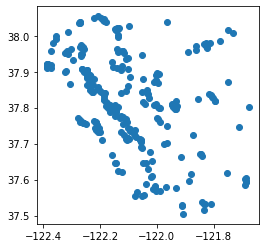

In [76]:
parks_df.plot()

In [77]:
# select the nodes in the network where parks are located

node_ids = transit_ped_net.get_node_ids(parks_df['geometry'].x, parks_df['geometry'].y)

In [78]:
# set a variable related to the park nodes in the network

transit_ped_net.set(node_ids, name='parks')

In [79]:
# calculate the variable for every origin node in the network
# as the number of park nodes within a maximum distance of it

maxdist = 30

access = transit_ped_net.aggregate(maxdist,
                           type='count',
                           decay='linear',
                           name='parks'
                          )

# Cap the variable at 5 parks
access= access.clip(upper=5)

access.describe()

count    357883.000000
mean          0.564006
std           1.226087
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.000000
dtype: float64

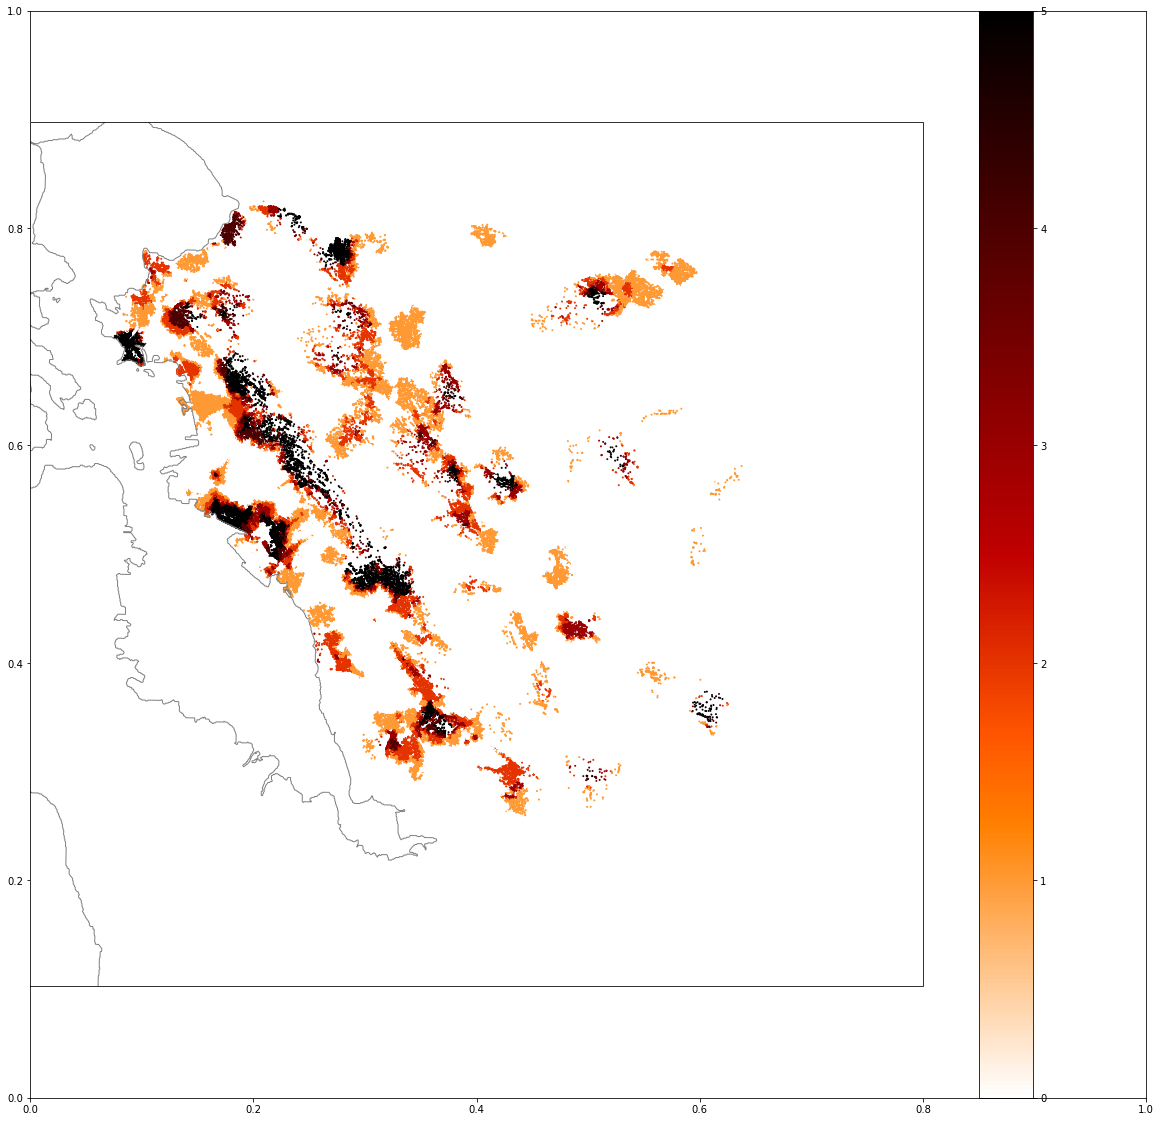

In [80]:
# plot the number of parks within the maximum distance
# of each node in the network

fig = plt.subplots(figsize=(20,20))

data_crs = ccrs.PlateCarree()
ax = plt.axes(projection=ccrs.epsg(26943))
ax.add_feature(cartopy.feature.GSHHSFeature(scale='full'), edgecolor='grey')

plt.scatter(transit_ped_net.nodes_df.x, transit_ped_net.nodes_df.y, 
            c=access, s=4, cmap='gist_heat_r', edgecolor='none', transform=data_crs)
cb = plt.colorbar()

In [81]:
# set the park entrance locations on the network

maxdist = 60

transit_ped_net.set_pois(category='park',
                 maxdist=maxdist,
                 maxitems=3,
                 x_col=centroids.x, 
                 y_col=centroids.y)

In [82]:
# calculate travel time to nearest park entrance from each node in network

distances = transit_ped_net.nearest_pois(distance=maxdist,
                                 category='park',
                                 num_pois=3)
distances.astype(int).head()

1   2   3
id_int            
1       37  37  38
2       35  36  41
3       34  36  41
4       34  35  40
5       33  34  39

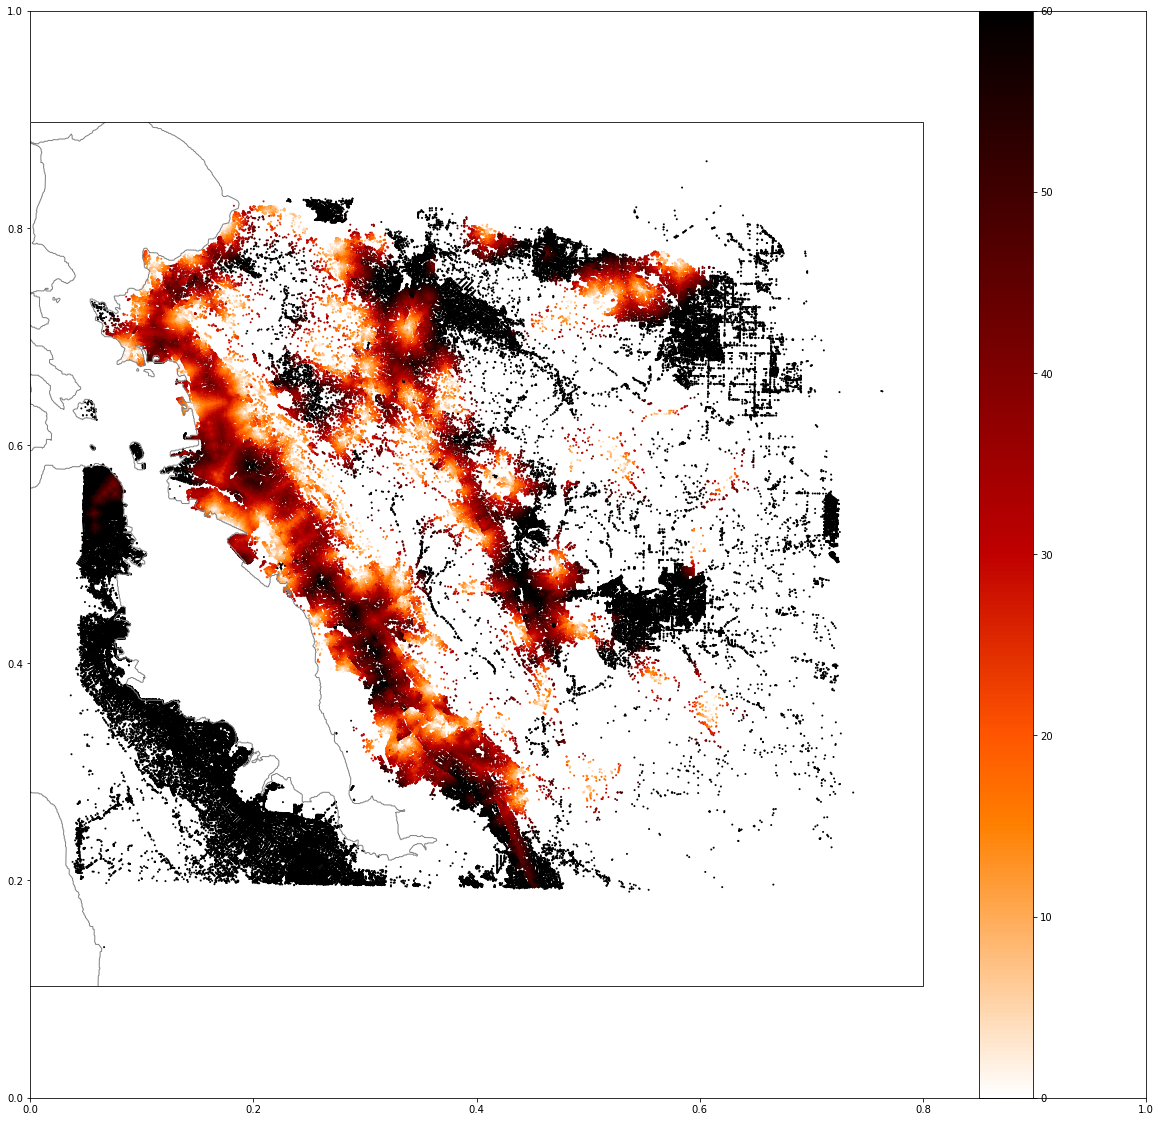

In [83]:
# Visualize travel time to the nearest park entrance from each node on the network
# Limited to nodes that are within 60 mins max travel time.

fig = plt.subplots(figsize=(20,20))

data_crs = ccrs.PlateCarree()
ax = plt.axes(projection=ccrs.epsg(26943))
ax.add_feature(cartopy.feature.GSHHSFeature(scale='full'), edgecolor='grey')

plt.scatter(transit_ped_net.nodes_df.x, transit_ped_net.nodes_df.y, 
            c=distances[1], s=4, cmap='gist_heat_r', edgecolor='none', transform=data_crs)
cb = plt.colorbar()

## Format the output as a spatial data layer

In [84]:
# Create a GeoDataFrame with the location of each
# origin node in the network and the
# distance to the nearest park entrance

# Extract the locations of the origin nodes in the network
geometry = gpd.points_from_xy(x = transit_ped_net.nodes_df['x'],
                              y = transit_ped_net.nodes_df['y'])

# Create the GeoDataFrame with the distance data
distances_gdf = gpd.GeoDataFrame(distances[1], geometry=geometry)

# Clean up the GDF columns, index, and crs
distances_gdf.rename(columns={1:'distance'}, inplace=True)
distances_gdf.reset_index(drop=True, inplace=True)
distances_gdf.crs = "EPSG:4326"

print(distances_gdf.shape)
distances_gdf.head()

(357883, 2)


distance                     geometry
0  37.085999  POINT (-122.10464 37.68833)
1  35.136002  POINT (-122.09918 37.68424)
2  34.585999  POINT (-122.09765 37.68303)
3  34.035999  POINT (-122.09609 37.68178)
4  33.236000  POINT (-122.09381 37.67993)

In [85]:
# Save as a GeoJSON file

distances_gdf.to_file("data/transit_distance.geojson", driver='GeoJSON')